In [ ]:
from music21 import converter, instrument, note, chord, stream
import numpy
from matplotlib import pyplot as plt
import keras
from sklearn.preprocessing import OneHotEncoder
from keras import Sequential, Model, regularizers
from keras.layers import LSTM, Dropout, Dense, Activation, Input, concatenate
import pandas as pd
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten, Attention, Bidirectional
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Embedding
import tensorflow as tf
from tqdm import tqdm
import numpy as np

In [ ]:
!unzip dataset.zip

unzip:  cannot find or open dataset.zip, dataset.zip.zip or dataset.zip.ZIP.


In [ ]:
def get_notes(midi):
  notes = []

  notes_from_midi = midi.flatten().notesAndRests
  notes_sorted = sorted(notes_from_midi, key=lambda note: note.offset)

  prev_start = notes_sorted[0].offset

  for element in notes_sorted:
    if isinstance(element , note.Note):
      notes.append((float(element.offset), float(element.volume.velocity),float(element.seconds), str(element.pitch), float(element.offset-prev_start)))
    elif isinstance(element, chord.Chord):
      #notes.append((float(element.offset), float(element.volume.velocity), float(element.seconds), '+'.join(str(n) for n in element.normalOrder)))
      for noteChord in element.pitches:
        notes.append((float(element.offset),float(element.volume.velocity), float(element.seconds), str(noteChord), float(element.offset-prev_start)))

    elif isinstance(element, note.Rest):
        # Bizarre car main gauche et droite flatten (réunie)
        # Voir autre implémentation
        notes.append((float(element.offset), 0,float(element.seconds), "REST", float(element.offset-prev_start)))

    prev_start = element.offset
  return notes



In [ ]:
input_note, output_note = [], []
input_offset, output_offset = [], []
input_volume, output_volume = [], []
input_duration, output_duration = [], []

note_all_songs = []
for folder in tqdm(os.walk("dataset")):
    if len(folder) != 3:
      continue
    else:
      for file in folder[2]:
        file_path = str(folder[0])+"/"+file

        # convertit la piste midi
        midi = converter.parse(file_path)

        # récupère les notes, volume, dureées...
        notes = get_notes(midi)

        # ajoute à une liste globale
        note_all_songs.append(notes)

2it [00:02,  1.12s/it]


In [ ]:
# fais un dataframe à partir de toutes les notes (sans distinctions)
df = pd.DataFrame([], columns=['debut_note','volume','durée(s)', 'pitch/chord', 'offset'])
df = df.reset_index(drop=True)
for elem in note_all_songs:
    df2 = pd.DataFrame(elem, columns=['debut_note','volume','durée(s)', 'pitch/chord', 'offset'])
    df2 = df2.reset_index(drop=True)
    df =pd.concat([df,df2])
    df = df.reset_index(drop=True)

In [ ]:
def check_pitch(x):
  if ('+' in x) or x.isdigit():
        notes_in_chord = x.split('+')
        notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.Piano()
            notes.append(new_note)
        new_chord =chord.Chord(notes).pitches[0].midi
        return new_chord
    # pattern is a note
  elif 'REST' in x:
    return 0
  else:
        new_note = note.Note(x).pitch.midi
        return new_note

In [ ]:
df['nombre_de_notes_simultanees'] = 0

# Triez le DataFrame par colonne 'offset'
df = df.sort_values(by='debut_note')

def compter_notes_simultanees(row):
    return df[(df['debut_note'] <= row['debut_note']) & (df['debut_note'] + df['durée(s)'] >= row['debut_note'])].shape[0]

# Appliquez la fonction compter_notes_simultanees à chaque ligne du DataFrame
df['nombre_de_notes_simultanees'] = df.apply(compter_notes_simultanees, axis=1)


In [ ]:
df

,debut_note,volume,durée(s),pitch/chord,offset
0,0.0,80.0,1.000000,B-3,0.0
1,0.0,80.0,1.000000,F#3,0.0
2,0.0,80.0,1.500000,B-1,0.0
3,2.0,80.0,0.500000,G#3,2.0
4,3.0,80.0,0.500000,E-3,1.0
...,...,...,...,...,...
2298,228.0,78.0,1.818182,E1,0.0
2299,228.0,78.0,1.818182,E2,0.0
2300,232.0,64.0,1.818182,B3,4.0
2301,232.0,78.0,1.818182,E1,0.0


In [ ]:
#train les encoders pour les notes, volumes et durées en catégorielles (one hot)
# sur intégralité des données (obligé)
# Voir si on peut pas enregistré le transformateur
oh_notes =  OneHotEncoder().fit(df[['pitch/chord']])


# seuil/catégories modifiable
dict_volume_class = {
    "very low":10,
    "low":30,
    "low medium":50,
    "medium":70,
    "high": 90,
    "very high":128
}
bins_volume = list(dict_volume_class.values())
bins_volume.insert(0,-0.1)
values_volume = list(dict_volume_class.keys())
df["volume_class"] = pd.cut(df["volume"], bins=bins_volume, labels=values_volume)
"""df["volume_class_interval"] = pd.cut(df["volume"], bins=20)
intervals = df["volume_class_interval"]
median_values = [(interval.left + interval.right) / 2 for interval in intervals]
df["volume_class"] = median_values"""
oh_volume =  OneHotEncoder().fit(df[['volume_class']])


dict_duration_class = {
"very short" : 0.1,
"short" :0.25,
"medium":0.5,
"medium-long":0.75,
"long":1.0,
"very long": 1.5,
"kilometer long":2.0,
"yearlight distance":3.0,
"super mega long":df['durée(s)'].max() if df['durée(s)'].max()>3.0 else 4.0
}
bins_duration = list(dict_duration_class.values())
bins_duration.insert(0,-0.1)
values_duration = list(dict_duration_class.keys())
df["duration_class"] = pd.cut(df["durée(s)"], bins=bins_duration, labels=values_duration)
"""df["duration_class_interval"] = pd.cut(df["durée(s)"], bins=20)
intervals = df["duration_class_interval"]
median_values = [(interval.left + interval.right) / 2 for interval in intervals]
df["duration_class"] = median_values"""
oh_duration =  OneHotEncoder().fit(df[['duration_class']])


In [ ]:
df['volume_class'].value_counts()

high          3274
very low       777
medium           4
low              0
low medium       0
very high        0
Name: volume_class, dtype: int64

In [ ]:
def prepare_sequence(data, sequence_length, network_input, network_output):
  # create input sequences and the corresponding outputs
  for i in range(0, len(data) - sequence_length, 1):
      sequence_in = data[i:i + sequence_length]
      sequence_out = data[i + sequence_length]
      network_input.append(sequence_in)
      network_output.append(sequence_out)
  return (network_input, network_output)

def reshape_array_input(array_tensor, sequence_length):
  n_patterns = len(array_tensor)
  array_reshaped = numpy.reshape(array_tensor, (n_patterns, sequence_length, -1))
  return array_reshaped

def reshape_array_output(array_tensor, sequence_length):
  n_patterns = len(array_tensor)
  array_reshaped = numpy.reshape(array_tensor, (len(array_tensor), -1))
  return array_reshaped


In [ ]:
sequence_length = 25

In [ ]:
input_note, output_note = [], []
input_offset, output_offset = [], []
input_volume, output_volume = [], []
input_duration, output_duration = [], []
input_step, output_step = [], []
input_simul, output_simult = [],[]

# pour chaque music, on la transforme en dataframe, transforme les notes, durées et volumes
for music in note_all_songs:
  df_music = pd.DataFrame(music, columns=['debut_note','volume','durée(s)', 'pitch/chord', 'step'])

  # encode le volume et la durée
  df_music["volume_class"] = pd.cut(df_music["volume"], bins=bins_volume, labels=values_volume)
  df_music["duration_class"] = pd.cut(df_music["durée(s)"], bins=bins_duration, labels=values_duration)
  #df_music['nombre_de_notes_simultanees'] = df_music.apply(compter_notes_simultanees, axis=1)


  # transform en one hot à partir des modèles entrainés
  notes_encoded = oh_notes.transform(df_music[['pitch/chord']]).toarray()
  volume_encoded = oh_volume.transform(df_music[['volume_class']]).toarray()
  duration_encoded = oh_duration.transform(df_music[['duration_class']]).toarray()

  # prépare les input (longeur = sequence_length) pour chaque morceau
  # garde certaine cohérence au morceau même
  input_offset, output_offset = prepare_sequence(df_music['debut_note'].values, sequence_length, input_offset, output_offset)
  input_note, output_note = prepare_sequence(notes_encoded, sequence_length, input_note, output_note)
  input_volume, output_volume = prepare_sequence(volume_encoded, sequence_length, input_volume, output_volume)
  #input_duration, output_duration = prepare_sequence(duration_encoded, sequence_length, input_duration, output_duration)
  input_duration, output_duration = prepare_sequence(df_music["durée(s)"].values, sequence_length, input_duration, output_duration)

  input_step, output_step = prepare_sequence(df_music['step'].values, sequence_length, input_step, output_step)
  #input_simul, output_simult = prepare_sequence(df_music['nombre_de_notes_simultanees'].values, sequence_length, input_simul, output_simult)

In [ ]:
# on reshape tout
input_note_reshaped= reshape_array_input(input_note, sequence_length)
output_note_reshaped = reshape_array_output(output_note, sequence_length)

input_offset_reshaped = reshape_array_input(input_offset, sequence_length)
output_offset_reshaped = reshape_array_output(output_offset, sequence_length)

input_volume_reshaped= reshape_array_input(input_volume, sequence_length)
output_volume_reshaped = reshape_array_output(output_volume, sequence_length)

input_duration_reshaped= reshape_array_input(input_duration, sequence_length)
output_duration_reshaped = reshape_array_output(output_duration, sequence_length)


input_step_reshaped= reshape_array_input(input_step, sequence_length)
output_step_reshaped = reshape_array_output(output_step, sequence_length)

"""input_simul = reshape_array_input(input_simul, sequence_length)
output_simult = reshape_array_output(output_simult, sequence_length)
"""

'input_simul = reshape_array_input(input_simul, sequence_length)\noutput_simult = reshape_array_output(output_simult, sequence_length)\n'

In [ ]:
input_note_reshaped

In [ ]:
#création du modèle (à alléger si overfitting)
inputNotes_layer = Input(shape=(input_note_reshaped.shape[1], input_note_reshaped.shape[2]))
inputNotes = (LSTM(
        256,
        input_shape=(input_note_reshaped.shape[1], input_note_reshaped.shape[2]),
        dropout=0.3,
        return_sequences=True
    ))(inputNotes_layer)

inputVolume_layer = Input(shape=(input_volume_reshaped.shape[1], input_volume_reshaped.shape[2]))
inputVolume = (LSTM(
        256,
        input_shape=(input_volume_reshaped.shape[1], input_volume_reshaped.shape[2]),
        dropout=0.3,
        return_sequences=True
    ))(inputVolume_layer)

inputDuration_layer = Input(shape=(input_duration_reshaped.shape[1], input_duration_reshaped.shape[2]))
inputDuration = BatchNormalization()(inputDuration_layer)
inputDuration =(LSTM(
        256,
        input_shape=(input_duration_reshaped.shape[1], input_duration_reshaped.shape[2]),
        dropout=0.3,
        return_sequences=True,
    ))(inputDuration_layer)

"""inputOffset_layer = Input(shape=(input_offset_reshaped.shape[1], input_offset_reshaped.shape[2]))
inputOffset = LSTM(
        32,
        input_shape=(input_offset_reshaped.shape[1], input_offset_reshaped.shape[2]),
        return_sequences=True
    )(inputOffset_layer)"""

inputStep_layer = Input(shape=(input_step_reshaped.shape[1], input_step_reshaped.shape[2]))
inputStep = BatchNormalization()(inputStep_layer)
inputStep = (LSTM(
        256,
        dropout=0.3,
        input_shape=(input_step_reshaped.shape[1], input_step_reshaped.shape[2]),
        return_sequences=True
    ))(inputStep_layer)



attention_notes = Attention()([inputNotes, inputStep, inputDuration])

inputs = concatenate([inputNotes, inputVolume, inputDuration, inputStep, attention_notes])

x = LSTM(512, return_sequences=True, dropout=0.3)(inputs)
x = LSTM(512)(inputs)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(512)(x)

outputNotes = Dense(256)(x)
outputNotes = Dropout(0.3)(outputNotes)
outputNotes = Dense(output_note_reshaped.shape[1], activation=None, name="Note")(outputNotes)

outputVolume = Dense(256)(x)
outputVolume = BatchNormalization()(outputVolume)
outputVolume = Dropout(0.3)(outputVolume)
outputVolume = Dense(output_volume_reshaped.shape[1], activation='softmax', name="Volume")(outputVolume)

outputDuration = Dense(512)(x)
#outputDuration = BatchNormalization()(outputDuration)
outputDuration = Dropout(0.1)(outputDuration)
outputDuration = Dense(output_duration_reshaped.shape[1], activation="linear", name="Duration")(outputDuration)

outputOffset =  Dense(512)(x)
#outputOffset = BatchNormalization()(outputOffset)
outputOffset = Dropout(0.1)(outputOffset)
outputOffset = Dense(output_step_reshaped.shape[1], activation="linear", name="Offset")(outputOffset)



model = Model(inputs=[inputNotes_layer,inputStep_layer,  inputVolume_layer, inputDuration_layer], outputs=[outputNotes, outputOffset, outputVolume, outputDuration])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)


In [ ]:
loss_weights = [1,1.0,1,1.0]
#loss_weights = [0.5,2.0,0.3,1.0]

In [ ]:
metrics = {
    "Note" : 'accuracy',
    "Volume" : 'accuracy',
    "Offset": "mean_absolute_error",
    "Duration": "mean_absolute_error"
}

In [ ]:
model.compile(metrics=metrics,loss=[tf.keras.losses.CategoricalCrossentropy(from_logits=True), mse_with_positive_pressure, "categorical_crossentropy", mse_with_positive_pressure], optimizer=optimizer, loss_weights=loss_weights)

In [ ]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_25 (InputLayer)       [(None, 25, 57)]             0         []                            
                                                                                                  
 input_27 (InputLayer)       [(None, 25, 1)]              0         []                            
                                                                                                  
 input_28 (InputLayer)       [(None, 25, 1)]              0         []                            
                                                                                                  
 lstm_36 (LSTM)              (None, 25, 256)              321536    ['input_25[0][0]']            
                                                                                            

In [ ]:
import os

cp_callback = keras.callbacks.ModelCheckpoint(
    'model_weights_epoch3.h5',  # Nom du fichier de sauvegarde avec un espace réservé pour le numéro de l'époque
    save_weights_only=True,  # Sauvegarder uniquement les poids, pas l'ensemble du modèle
    verbose=1  # Afficher un message lors de la sauvegarde
    )

In [ ]:
history = model.fit([input_note_reshaped, input_step_reshaped,  input_volume_reshaped, input_duration_reshaped], [output_note_reshaped, output_step_reshaped, output_volume_reshaped, output_duration_reshaped], epochs=400, callbacks=[cp_callback])

Epoch 1/400
68/69 [============================>.] - ETA: 0s - loss: 10.5886 - Note_loss: 3.9432 - Offset_loss: 2.4499 - Volume_loss: 1.9260 - Duration_loss: 2.2696 - Note_accuracy: 0.0882 - Offset_mean_absolute_error: 0.7589 - Volume_accuracy: 0.4067 - Duration_mean_absolute_error: 0.8259
Epoch 1: saving model to model_weights_epoch3.h5
69/69 [==============================] - 124s 23ms/step - loss: 10.5845 - Note_loss: 3.9426 - Offset_loss: 2.4479 - Volume_loss: 1.9263 - Duration_loss: 2.2677 - Note_accuracy: 0.0886 - Offset_mean_absolute_error: 0.7586 - Volume_accuracy: 0.4068 - Duration_mean_absolute_error: 0.8255
Epoch 2/400
68/69 [============================>.] - ETA: 0s - loss: 6.3593 - Note_loss: 3.4729 - Offset_loss: 0.6802 - Volume_loss: 1.5833 - Duration_loss: 0.6229 - Note_accuracy: 0.1347 - Offset_mean_absolute_error: 0.5485 - Volume_accuracy: 0.4926 - Duration_mean_absolute_error: 0.6067
Epoch 2: saving model to model_weights_epoch3.h5
69/69 [============================

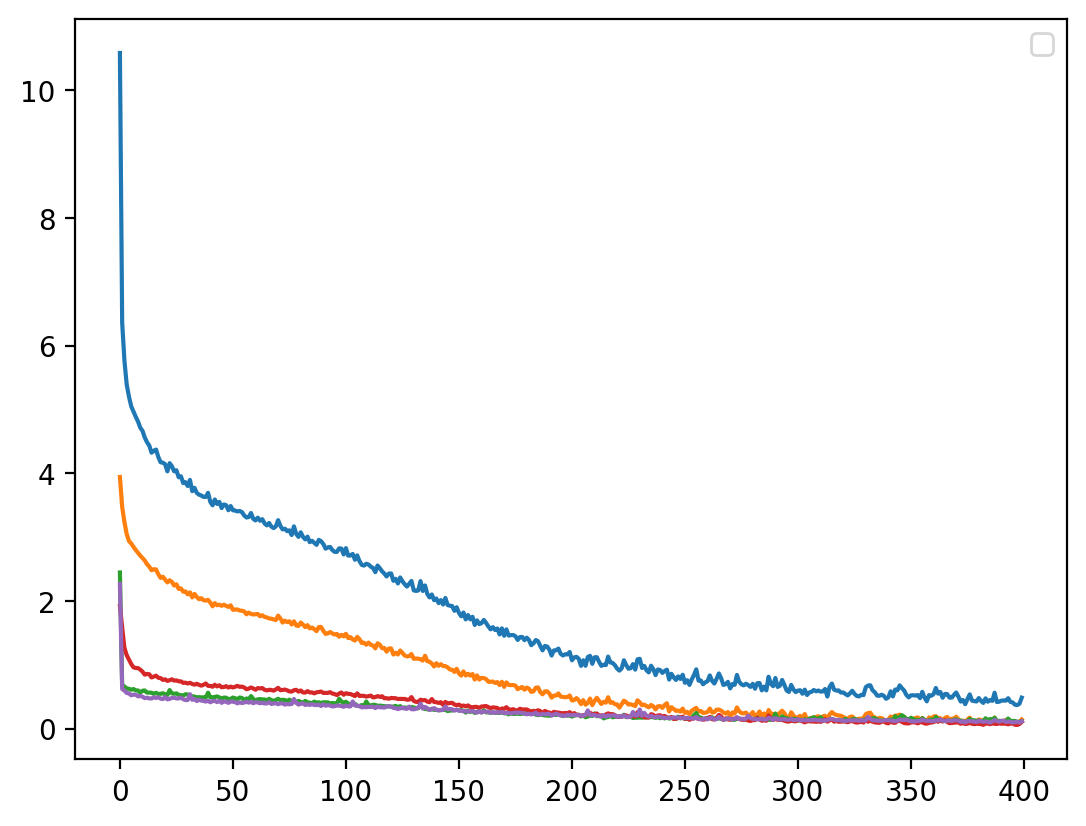

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['Note_loss'])
plt.plot(history.history['Offset_loss'])
plt.plot(history.history['Volume_loss'])
plt.plot(history.history['Duration_loss'])
plt.legend()
plt.show()

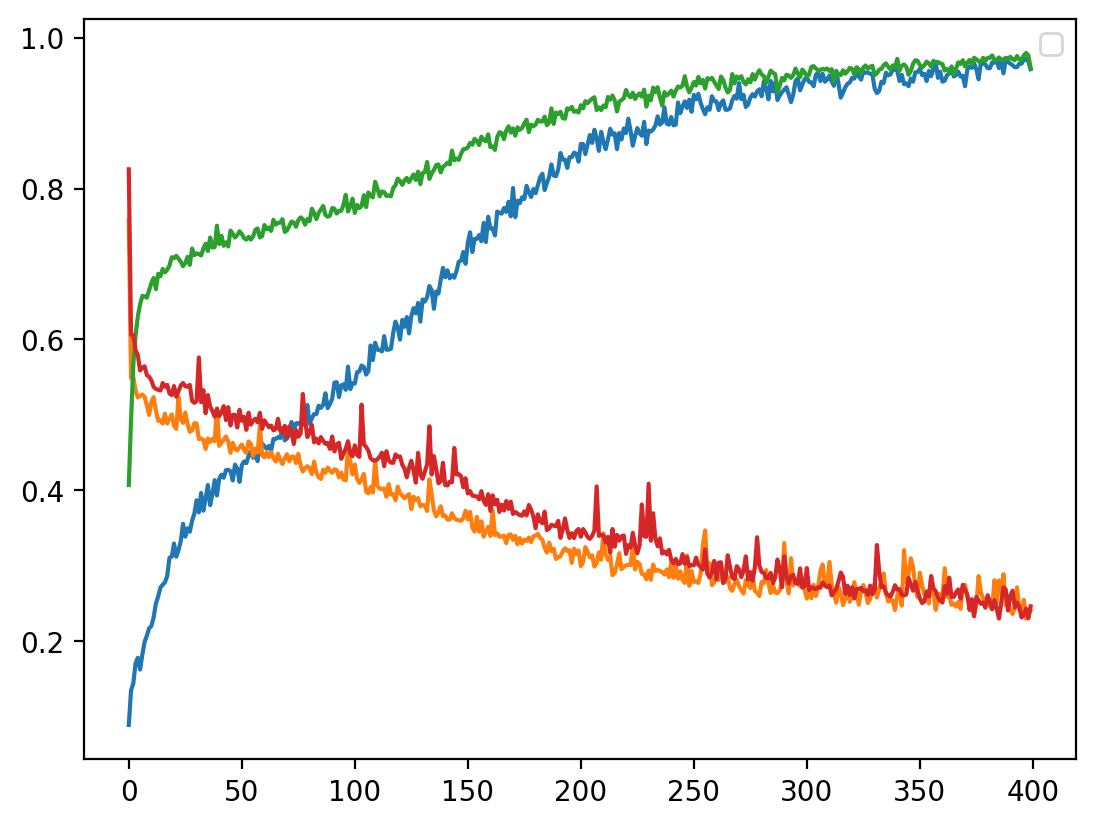

In [ ]:
plt.plot(history.history['Note_accuracy'])
plt.plot(history.history['Offset_mean_absolute_error'])
plt.plot(history.history['Volume_accuracy'])
plt.plot(history.history['Duration_mean_absolute_error'])
plt.legend()
plt.show()

In [ ]:
midi = converter.parse("dataset/Sweden.mid")
notes = get_notes(midi)

df_input_predict = pd.DataFrame(notes, columns=['debut_note','volume','durée(s)', 'pitch/chord', 'step'])



In [ ]:
df_input_predict

,debut_note,volume,durée(s),pitch/chord,step
0,0.00,50.0,0.708550,C#5,0.00
1,0.00,42.0,0.944733,A3,0.00
2,0.00,42.0,0.944733,E4,0.00
3,0.00,0.0,0.708550,REST,0.00
4,0.75,43.0,0.213098,D5,0.75
...,...,...,...,...,...
7371,951.00,73.0,0.138889,C#3,0.00
7372,951.00,73.0,0.138889,E3,0.00
7373,951.00,73.0,0.138889,A3,0.00
7374,951.25,0.0,0.972222,REST,0.25


In [ ]:
input_note_input_predict, output_note_input_predict = [], []
input_offset_input_predict, output_offset_input_predict = [], []
input_volume_input_predict, output_volume_input_predict = [], []
input_duration_input_predict, output_duration_input_predict = [], []
input_step_input_predict, output_step_input_predict = [], []

In [ ]:

# encode le volume et la durée
df_input_predict["volume_class"] = pd.cut(df_input_predict["volume"], bins=bins_volume, labels=values_volume)
df_input_predict["duration_class"] = pd.cut(df_input_predict["durée(s)"], bins=bins_duration, labels=values_duration)


# transform en one hot à partir des modèles entrainés
notes_encoded = oh_notes.transform(df_input_predict[['pitch/chord']]).toarray()
volume_encoded = oh_volume.transform(df_input_predict[['volume_class']]).toarray()
duration_encoded = oh_duration.transform(df_input_predict[['duration_class']]).toarray()

# prépare les input (longeur = sequence_length) pour chaque morceau
# garde certaine cohérence au morceau même
input_offset_input_predict, output_offset_input_predict = prepare_sequence(df_input_predict['debut_note'].values, sequence_length, input_offset_input_predict, output_offset_input_predict)
input_note_input_predict, output_note_input_predict = prepare_sequence(notes_encoded, sequence_length, input_note_input_predict, output_note_input_predict)
input_volume_input_predict, output_volume_input_predict = prepare_sequence(volume_encoded, sequence_length, input_volume_input_predict, output_volume_input_predict)
#input_duration, output_duration = prepare_sequence(duration_encoded, sequence_length, input_duration, output_duration)
input_duration_input_predict, output_duration_input_predict = prepare_sequence(df_input_predict["durée(s)"].values, sequence_length, input_duration_input_predict, output_duration_input_predict)

input_step_input_predict, output_step_input_predict = prepare_sequence(df_input_predict['step'].values, sequence_length, input_step_input_predict, output_step_input_predict)

In [ ]:
#prend une séquence de notes, volume, durées
"""pattern_note = input_note[0]
pattern_offset = input_offset[0]
pattern_volume = input_volume[0]
pattern_duration = input_duration[0]
pattern_step = input_step[0]"""

pattern_note = input_note_input_predict[0]
pattern_offset = input_offset_input_predict[0]
pattern_volume = input_volume_input_predict[0]
pattern_duration = input_duration_input_predict[0]
pattern_step = input_step_input_predict[0]


In [ ]:
model.load_weights('/content/model_weights_epoch1.h5')

In [ ]:
# prediction time
prediction_output = []


prev_start = pattern_offset[-1]
for i in tqdm(range(200)):

    #on reshape les input à prédire
    note_prediction_input = numpy.reshape(pattern_note, (1, len(pattern_note), -1))
    volume_prediction_input = numpy.reshape(pattern_volume, (1, len(pattern_volume), -1))
    duration_prediction_input = numpy.reshape(pattern_duration, (1, len(pattern_duration), -1))
    offset_prediction_input = numpy.reshape(pattern_offset, (1, len(pattern_offset), 1))
    step_prediction_input = numpy.reshape(pattern_step, (1, len(pattern_step), 1))

    #prédit ici
    prediction = model.predict([note_prediction_input, step_prediction_input, volume_prediction_input, duration_prediction_input], verbose=0)
    # prédis la note en récupérant l'index max du softmax et en faisant la transofr inverse
    # à partir du one hot train sur les notes


    note_softmax = prediction[0]

    notes_pred = np.zeros(len(pattern_note[0]))
    notes_pred[np.argmax(prediction[0])] = 1

    a = note_softmax[0] / 1.0
    a = np.array(a, dtype=np.float64)
    max_logit = np.max(a)
    a = np.exp(a) / np.sum(np.exp(a))
    sample = np.random.multinomial(1, a)


    result_note = oh_notes.inverse_transform(sample.reshape(1, -1))
    pattern_note = numpy.concatenate([pattern_note, [sample]])
    pattern_note = pattern_note[1:]
    """result_note = oh_notes.inverse_transform(notes_pred.reshape(1, -1))
    pattern_note = numpy.concatenate([pattern_note, [notes_pred]])
    pattern_note = pattern_note[1:]"""


    """offset_predict = prediction[1][0][0]
    pattern_offset = numpy.concatenate([pattern_offset, prediction[1][0]])
    pattern_offset = pattern_offset[1:]
    print(pattern_offset)"""



    step_predict = prediction[1][0][0]
    pattern_step = numpy.concatenate([pattern_step, prediction[1][0]])
    prev_start += step_predict
    pattern_offset = numpy.concatenate([pattern_offset, [prev_start]])

    pattern_step = pattern_step[1:]
    pattern_offset = pattern_offset[1:]

    # la même avec le volume
    volume_pred = np.zeros(len(pattern_volume[1]))
    volume_pred[np.argmax(prediction[2])] = 1
    result_volume = oh_volume.inverse_transform(volume_pred.reshape(1, -1))
    pattern_volume = numpy.concatenate([pattern_volume, [volume_pred]])
    pattern_volume = pattern_volume[1:]

    # la même avec la durée
    #duration_pred = np.zeros(len(pattern_duration[0]))
    #duration_pred[np.argmax(prediction[3])] = 1
    #result_duration = oh_duration.inverse_transform(duration_pred.reshape(1, -1))
    duration_pred = prediction[3][0][0]
    duration_pred_rounded = round(duration_pred,3)
    pattern_duration = numpy.concatenate([pattern_duration, [duration_pred]])
    pattern_duration = pattern_duration[1:]

    # comme on prédit un mot associé au volume, on associe au mot une valeur/intensité
    #(manque des catégories)
    volume_encoded = result_volume[0][0]
    volume_decoded = dict_volume_class[volume_encoded]

    # la même avec la durée
    #(manque des catégories)
    #duration_encoded = result_duration[0][0]
    #duration_decoded = dict_duration_class[duration_encoded]


    #on ajoute la note, le volyme et la durée
    prediction_output.append([result_note[0][0], step_predict, volume_decoded, duration_pred_rounded])


100%|██████████| 200/200 [00:15<00:00, 12.69it/s]


In [ ]:
df_real_output = df_input_predict[25:226]
df_real_output["debut_note"]  = df_real_output["debut_note"] - df_real_output["debut_note"].min()
df_real_output["MIDI Pitch"] = df_real_output['pitch/chord'].apply(check_pitch)

<ipython-input-169-7daf124bf38b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_real_output["debut_note"]  = df_real_output["debut_note"] - df_real_output["debut_note"].min()
<ipython-input-169-7daf124bf38b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_real_output["MIDI Pitch"] = df_real_output['pitch/chord'].apply(check_pitch)


In [ ]:
df_output_predict = pd.DataFrame(prediction_output, columns=['note','durée(s)','volume', 'step'])
df_output_predict["debut_note"] = df_output_predict.step.cumsum()
df_output_predict["MIDI Pitch"] = df_output_predict['note'].apply(check_pitch)


In [ ]:
df_real_output.head(5)

,debut_note,volume,durée(s),pitch/chord,step,volume_class,duration_class,MIDI Pitch
25,0.0,71.0,1.25,B2,1.0,high,very long,47
26,1.0,56.0,2.50,F#3,1.0,medium,yearlight distance,54
27,1.0,56.0,2.50,A3,1.0,medium,yearlight distance,57
28,1.0,56.0,2.50,C#4,1.0,medium,yearlight distance,61
29,1.0,62.0,1.25,A2,0.0,medium,very long,45


In [ ]:
df_output_predict.head(5)

,note,durée(s),volume,step,debut_note,MIDI Pitch
0,B2,0.825758,90,1.180,1.180000,47
1,F#3,0.842110,70,2.482,3.662000,54
2,A3,0.950842,70,2.347,6.009000,57
3,C#4,0.928092,70,2.443,8.452000,61
4,A2,0.353239,70,1.476,9.927999,45


In [ ]:
from music21.duration import Duration


In [ ]:
offset = 0
output_notes = []
# on passes des prédicitons à un format écoutable à l'oreille

prev_start = 0
resolution = 480
# pour chaque note prédite
for note_p in prediction_output:
    pattern = note_p[0]
    # si note = chord
    if ('+' in pattern) or pattern.isdigit():
        notes_in_chord = pattern.split('+')
        notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.Piano()
            notes.append(new_note)
        new_chord = chord.Chord(notes)
        new_chord.offset = prev_start + note_p[1]
        #new_chord.offset = note_p[1]
        # met le volume associé
        new_chord.volume.velocity = note_p[2]
        # met la durée associée
        new_chord.duration = Duration(note_p[3])
        output_notes.append(new_chord)
    # si note est un rest
    elif('REST'in pattern):
      note_rest = note.Rest()
      note_rest.offset = prev_start + note_p[1]
      #note_rest.offset = note_p[1]
      # durée associée (pas de volume car silencieux)
      note_rest.duration = Duration(quarterLength = note_p[3] * resolution / 60)
      output_notes.append(note_rest)
    else:
        new_note = note.Note(pattern)
        new_note.offset = prev_start + note_p[1]
        #new_note.offset = note_p[1]
        new_note.volume.velocity = note_p[2]
        new_note.duration = Duration(quarterLength = note_p[3] * resolution / 60)
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)
    prev_start = prev_start + note_p[1]
    # increase offset each iteration so that notes do not stack
    #offset += 0.5

In [ ]:
#into midi
midi_stream = stream.Stream(output_notes)
midi_stream.write('midi', fp='test_outputNoteOneHot13SwedenT1.mid')

'test_outputNoteOneHot13SwedenT1.mid'